# Semi-Supervised Learning

ML models can be divided into three broad categories based on the labeling of data instances: a) supervised learning, b) unsupervised, and c) semisupervised. 

<img src="../images/semisup.png" alt="Semi Supervised Setting">

In a **supervised setting**, each instance is annotated with a label, and a typical task is to predict a label given an instance.  On the other hand, there is no label associated with an instance in an **unsupervised setting**. The key task is to identify hidden structures (e.g., groups) in the instance set. 

In a **semi-supervised setting**, some instances are labeled, and the rest are unlabeled. We can address both supervised and unsupervised tasks with this type of dataset. 

Think about applying a supervised method to a dataset that has unlabeled instances. In this case, we are required to discard unlabeled instances before training a supervised model. On the other hand, semi-supervised methods can take advantage of this additional unlabeled data to better capture the shape of the underlying data distribution and generalize better to new instances. These methods can perform well when we have a very small number of labeled points and many unlabeled points.


In this notebook, we will explore `LabelPropagation` method in **semisupervised learning**. In short, an unlabeled instance takes a class label that is consistent with its neighborhood data points. Scikit-learn also offers another semi-supervised method named `LabelSpreading`, which is similar to `LabelPropagation`. Both methods create a similarity matrix between instances and derive a propagation matrix from this similarity matrix. The difference between these methods lies in the way of creating a propagation/transition matrix from the similarity matrix. 


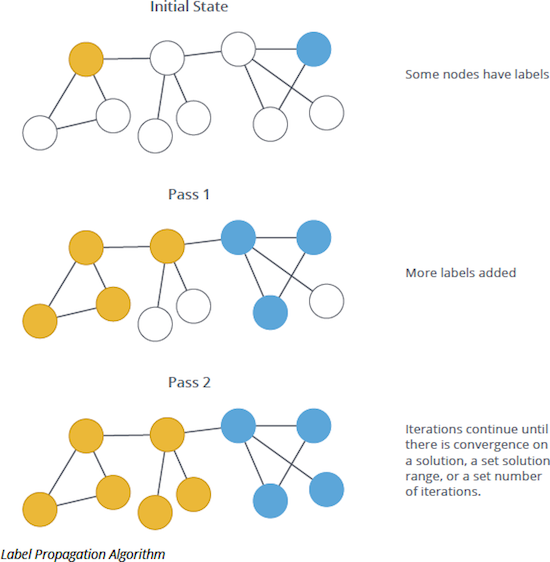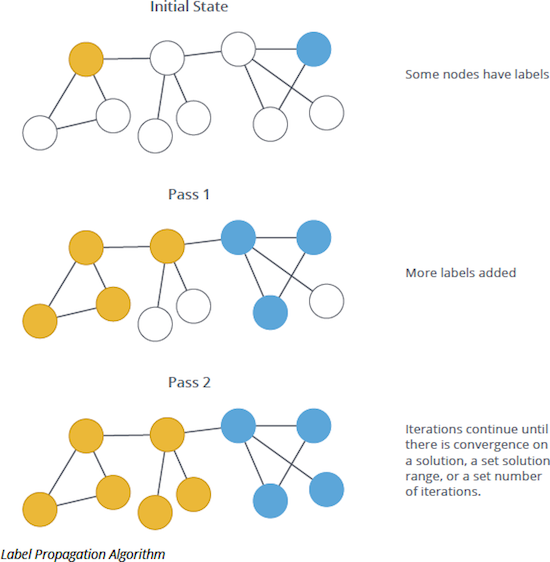

Source: [Graph Algorithms in Neo4j: Label Propagation](https://neo4j.com/blog/graph-algorithms-neo4j-label-propagation/)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from numpy import concatenate
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from seaborn import catplot

### Generating a synthetic dataset

For understanding semi-supervised learning, we will be using a synthetic dataset in this notebook. Scikit-learn `make_classification()` can be used to create a synthetic classification dataset. Let's create a dataset of 1000 instances with two features and two classes (binary classification). 

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_classes=2, n_informative=2, 
                           n_redundant=0, random_state=1)

### Transform the dataset

In the above dataset, all of the instances have labels. We need to ignore some labels to make them suitable for semi-supervised learning. We perform this transformation in two steps: 

1. We split the dataset into train and test datasets with an equal 50-50 split (we can vary this)
2. We then split the training dataset into two sets and ignore the labels of one of the sets. So, the final training set will have both labeled and unlabeled instances.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.50, random_state=1, stratify=y)

X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(
    X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)

### Summarizing the training and test sets

In [ ]:
print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
print('Unlabeled Train Set:', X_test_unlab.shape, y_test_unlab.shape)
print('Test Set:', X_test.shape, y_test.shape)

### Baseline performance on the semi-supervised learning dataset

We can establish a baseline by fitting a classifier only on the labeled training data. This is important because we would expect a semi-supervised learning algorithm to outperform a supervised learning algorithm that fits the labeled data alone. If this is not the case, we need to rethink about the semi-supervised model and/or data that we are using. 

In this notebook, we use a logistic regression method as a baseline. We fit this model with the labeled portion of the training dataset.

### Define and fit a logistic regression model

In [ ]:
model = LogisticRegression(C=20000, penalty='l2', max_iter=1000, random_state=0)
model.fit(X_train_lab, y_train_lab)

### Make predictions

In [ ]:
yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (acc*100))

The results may vary given the stochastic nature of the algorithm, evaluation procedure, and differences in numerical precision.

### Label Propagation for Semi-supervised learning

The label propagation model use `fit` function like other classification methods. This method expects that the class labels for the unlabeled instances will be denoted as -1. The model will then determine a class label for the unlabeled examples as part of fitting the model.

Now, we concatenate both labeled and unlabeled training sets into a single training set. 

In [ ]:
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

### Define and fit a label propagation model

In [ ]:
model_lp = LabelPropagation()
model_lp.fit(X_train_mixed, y_train_mixed)

model_ls = LabelSpreading()
model_ls.fit(X_train_mixed, y_train_mixed)

### Make predictions

In [ ]:
yhat = model_lp.predict(X_test)
score2 = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score2*100))

yhat = model_ls.predict(X_test)
score2 = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score2*100))

Here, the accuracy of the label propagation model is slightly higher than the baseline model.

As we have found new labels for the unlabeled instances, we use them for other downstream analyses. For example, we can now fit a supervised method on the entire training set with previously labeled data and predicted labeled data by the label propagation method. 


### Fit a supervised model using the estimated labels for the training dataset

Another approach we can use with the semi-supervised model is to take the estimated labels for the training dataset and fit a supervised learning model. We can then use these labels along with all of the input data to train and evaluate a supervised learning algorithm, such as a logistic regression model. The hope is that the supervised learning model trained on the entire training dataset would perform even better than the baseline and semi-supervised models. 

First, we need to retrieve the class labels for the entire training dataset from the label propagation model.

In [ ]:
# Get labels for entire training dataset data
tran_labels = model_lp.transduction_

### Define and fit the Logistic Regression model

In [ ]:
model_lr = LogisticRegression(C=20000, penalty='l2', max_iter=1000, random_state=0)
model_lr.fit(X_train_mixed, tran_labels)

### Make predictions and print accuracy

In [ ]:
yhat = model_lr.predict(X_test)
score3 = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score3*100))

### Discussion

In this case, we observe that this hierarchical/layered approach of a semi-supervised model followed by a supervised model achieves a better classification accuracy on the holdout dataset compared to the semi-supervised learning used alone.